In [103]:
import time
import requests
import torch
import torch.nn.functional as F
from torch import nn

# Set device: GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [104]:
# Download "Alice in Wonderland" from Project Gutenberg
url = "http://www.gutenberg.org/files/11/11-0.txt"
response = requests.get(url)
text = response.text

# For this lab, take the first 512 tokens
tokens = text.split()[:512]
print(f"Downloaded {len(tokens)} tokens.")

# Build a simple vocabulary and convert tokens to indices
vocab = {token: idx for idx, token in enumerate(set(tokens))}
indices = [vocab[token] for token in tokens]
indices = torch.tensor(indices, dtype=torch.long, device=device).unsqueeze(0)  # shape: (1, L)
L = indices.size(1)

Downloaded 512 tokens.


In [105]:
# Define embedding dimension and number of heads
embed_dim = 256
nheads = 8
head_dim = embed_dim // nheads  # should be integer (here 16)

# Create an embedding layer for our vocabulary
embedding = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_dim).to(device)

# Project embeddings into queries, keys, and values using linear layers
Wq = nn.Linear(embed_dim, embed_dim).to(device)
Wk = nn.Linear(embed_dim, embed_dim).to(device)
Wv = nn.Linear(embed_dim, embed_dim).to(device)

# Get token embeddings
x = embedding(indices)  # shape: (1, L, embed_dim)

# Compute Q, K, V: then reshape into (batch, L, nheads, head_dim)
Q = Wq(x).view(1, L, nheads, head_dim)
K = Wk(x).view(1, L, nheads, head_dim)
V = Wv(x).view(1, L, nheads, head_dim)


In [106]:
print(Q.shape)

torch.Size([1, 512, 8, 32])


In [107]:
def normal_attention(Q, K, V):
    #Get all shapes
    B, L, H, D = Q.shape
    scale = D ** -0.5 #Square root
    # Fuse batch and head for efficiency, matrix multiplication remains the same
    Q_ = Q.transpose(1, 2).reshape(B * H, L, D)  # (B*H, L, D)
    K_ = K.transpose(1, 2).reshape(B * H, L, D)  # (B*H, L, D)
    V_ = V.transpose(1, 2).reshape(B * H, L, D)  # (B*H, L, D)
    
    # Batch matrix multiplication, does the LxD * LxD --> LxL matrix multiplication for each B*H instance on a 3D tensor
    # Scale by square root of dimension
    attn_scores = torch.bmm(Q_, K_.transpose(1, 2)) * scale  # (B*H, L, L)
    # Make everything a probability
    attn_probs = F.softmax(attn_scores, dim=-1)  # (B*H, L, L)
    
    # Finally, after you have your Q K, do your V
    out = torch.bmm(attn_probs, V_)  # (B*H, L, D)
    
    # Reshape back to (B, L, H, D)
    out = out.reshape(B, H, L, D).transpose(1, 2)
    return out


In [108]:
try:
    from flash_attn import flash_attn_qkvpacked_func
except ImportError:
    raise ImportError("flash-attn not found. Please install it with: pip install flash-attn")

def flash_attention(qkv, dropout_p=0.0, causal=False):
    # Call the flash-attn function. Add dropout as you see fit, causal means it looks only "backwards" in the sequence when computing by applying zero masks
    out = flash_attn_qkvpacked_func(qkv, dropout_p=dropout_p, causal=causal)
    return out

In [109]:

def linear_attention(Q, K, V, eps=1e-6):
    """
    Kernel stuff.
    #https://egrigokhan.github.io/data/cs_229_br_Project_Report_KernelAttention.pdf - Kernel trick
    #https://arxiv.org/pdf/2009.14794 - Performer
    #https://paperswithcode.com/method/favor - Favoring
    φ(x) = elu(x) + 1
    Computes:
      y = (φ(Q) @ (φ(K)^T V)) / (φ(Q) @ (φ(K)^T 1))
    Q, K, V: (B, L, H, D)
    Returns output: (B, L, H, D)
    """
    phi = lambda x: F.elu(x) + 1
    B, L, H, D = Q.shape
    # Apply feature map elementwise
    Q_phi = phi(Q)  # (B, L, H, D)
    K_phi = phi(K)  # (B, L, H, D)
    
    # Transpose to shape (B, H, L, D)
    Q_phi = Q_phi.transpose(1, 2)
    K_phi = K_phi.transpose(1, 2)
    V = V.transpose(1, 2)
    
    # Compute numerator: for each head compute φ(Q) @ ( (φ(K)^T @ V) )
    KV = torch.matmul(K_phi.transpose(-2, -1), V)  # (B, H, D, D)
    numerator = torch.matmul(Q_phi, KV)  # (B, H, L, D)
    
    # Compute denominator: φ(Q) @ (φ(K)^T @ ones)
    ones = torch.ones(K_phi.shape[:-1] + (1,), device=K_phi.device)  # (B, H, L, 1)
    K_sum = torch.matmul(K_phi.transpose(-2, -1), ones)  # (B, H, D, 1)
    denominator = torch.matmul(Q_phi, K_sum)  # (B, H, L, 1)
    
    y = numerator / (denominator + eps)  # (B, H, L, D)
    y = y.transpose(1, 2)  # (B, L, H, D)
    return y

In [110]:

# Pack Q, K, V into one tensor: shape (B, L, 3, H, D)
qkv = torch.stack([Q.half(), K.half(), V.half()], dim=2)

###############################################
# Part 5: Compare Attention Implementations
###############################################

# Warm-up iterations
for _ in range(5):
    _ = normal_attention(Q, K, V)
    _ = flash_attention(qkv)
    _ = linear_attention(Q, K, V)

In [111]:


# Time normal attention
start = time.time()
normal_out = normal_attention(Q, K, V)
if device.type == 'cuda': torch.cuda.synchronize()
normal_time = time.time() - start

# Time Flash Attention
start = time.time()
flash_out = flash_attention(qkv)
if device.type == 'cuda': torch.cuda.synchronize()
flash_time = time.time() - start

# Time Linear Attention
start = time.time()
linear_out = linear_attention(Q, K, V)
if device.type == 'cuda': torch.cuda.synchronize()
linear_time = time.time() - start

print(f"Normal attention time: {normal_time*1000:.2f} ms")
print(f"Flash attention time:  {flash_time*1000:.2f} ms")
print(f"Linear attention time: {linear_time*1000:.2f} ms")

# Compare outputs: compute relative differences
diff_flash = torch.norm(normal_out - flash_out) / torch.norm(normal_out)
diff_linear = torch.norm(normal_out - linear_out) / torch.norm(normal_out)
print(f"Relative difference (Normal vs Flash):  {diff_flash.item():.4e}")
print(f"Relative difference (Normal vs Linear): {diff_linear.item():.4e}")

###############################################
# (Optional) Visualize a portion of the outputs
###############################################
# For instance, average over heads and print first 5 token representations
normal_avg = normal_out.mean(dim=2).squeeze(0)  # (L, D)
flash_avg = flash_out.mean(dim=2).squeeze(0)
linear_avg = linear_out.mean(dim=2).squeeze(0)

print("\nFirst 5 token representations (normal attention):")
print(normal_avg[:5])
print("\nFirst 5 token representations (flash attention):")
print(flash_avg[:5])
print("\nFirst 5 token representations (linear attention):")
print(linear_avg[:5])

Normal attention time: 1.49 ms
Flash attention time:  0.80 ms
Linear attention time: 0.96 ms
Relative difference (Normal vs Flash):  3.1815e-04
Relative difference (Normal vs Linear): 3.0219e-01

First 5 token representations (normal attention):
tensor([[-2.1756e-05,  3.2641e-02, -1.1363e-02,  6.2514e-04,  9.4590e-03,
          5.6709e-03,  3.5619e-02,  3.7037e-02, -3.2237e-02,  5.1495e-03,
          2.2321e-02,  3.8872e-02, -6.5262e-02,  1.4114e-02, -3.8732e-02,
          1.2479e-02,  1.0925e-02,  2.7176e-02, -3.5545e-03,  2.8619e-02,
          2.2766e-02,  4.3543e-02,  2.1709e-02, -2.8245e-02, -1.3215e-02,
          1.2096e-02,  1.1809e-02,  6.1791e-02,  1.6090e-02, -6.5931e-03,
          2.3705e-02, -3.2675e-02],
        [ 6.2338e-03,  2.4758e-02,  6.6691e-03, -8.4301e-03,  2.7448e-02,
         -8.4703e-03,  3.3059e-02,  4.3156e-02, -1.3518e-02,  1.0012e-02,
          1.6871e-02,  4.4614e-02, -5.1316e-02,  1.9046e-02, -3.1338e-02,
          4.8685e-03,  2.3625e-02,  1.8988e-02, -1.5

In [112]:
# For example, print the output for the first 5 tokens (averaged over heads)
normal_avg = normal_out.mean(dim=2).squeeze(0).detach().cpu().numpy()  # shape: (L, D)
flash_avg = flash_out.mean(dim=2).squeeze(0).detach().cpu().numpy()  
linear_avg = linear_out.mean(dim=2).squeeze(0).detach().cpu().numpy()  

In [113]:
import seaborn as sns
import numpy as np

In [114]:
normal_avg - flash_avg

array([[ 5.3644180e-07, -1.2934208e-05,  4.9918890e-06, ...,
        -1.3140962e-06,  7.9087913e-06, -2.1643937e-05],
       [ 5.9790909e-07, -6.8768859e-06,  2.0097475e-05, ...,
         6.9895759e-06, -6.6962093e-06, -1.3299286e-05],
       [-8.3502382e-06,  1.2591481e-05,  3.9283186e-06, ...,
         4.5141205e-06,  1.6395003e-05, -1.5612692e-05],
       ...,
       [-7.4598938e-06, -9.2275441e-06,  1.0520453e-05, ...,
         1.1902303e-06, -2.1059066e-05,  3.8966537e-06],
       [ 1.0857359e-05, -5.1558018e-06, -1.7171260e-07, ...,
        -1.8305145e-06,  7.2494149e-06, -2.8498471e-06],
       [-7.2289258e-06,  5.3625554e-06,  4.6836212e-06, ...,
         4.7776848e-07, -2.9653311e-06, -6.3199550e-06]], dtype=float32)

In [115]:
diff_2 = np.abs(normal_avg - flash_avg)
avg_2 = np.abs(normal_avg + flash_avg)/2

In [116]:
heatmap_input = diff_2/avg_2*100

/home/nikolas/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/nikolas/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


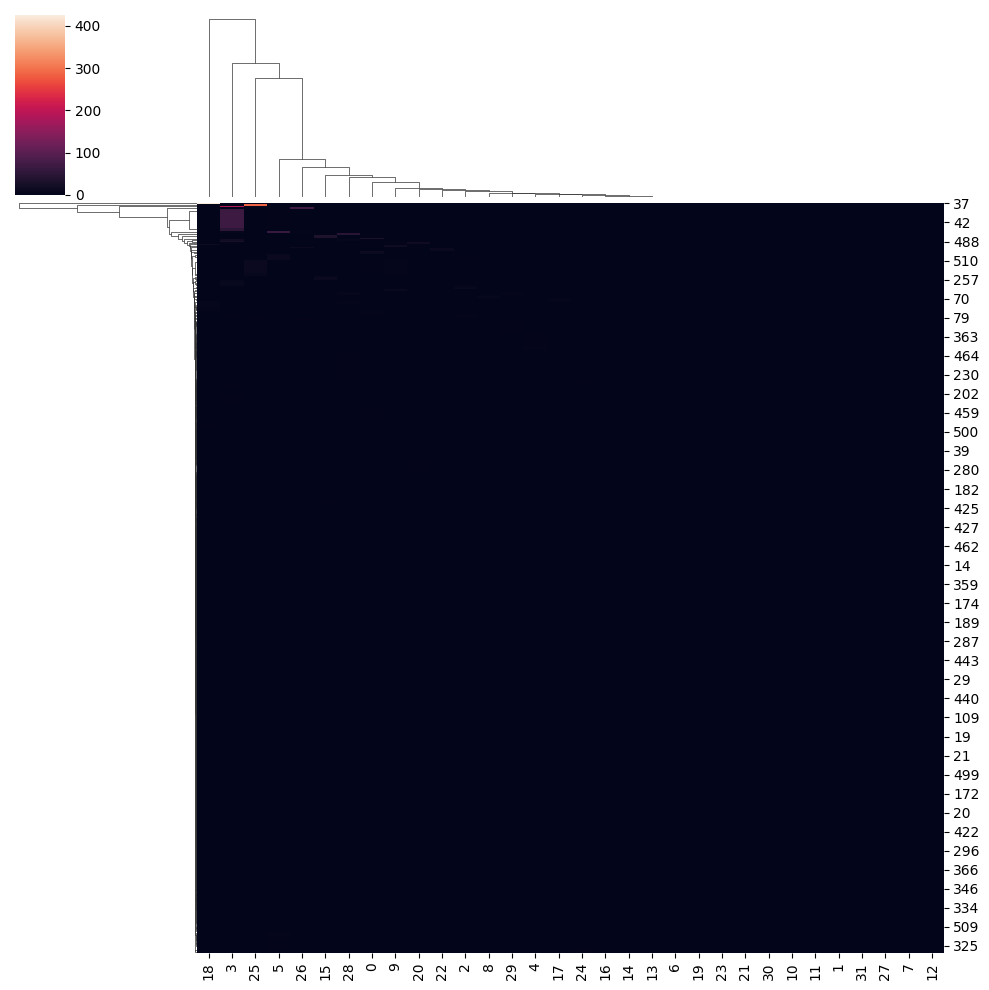

In [117]:
sns.clustermap(heatmap_input)

<Axes: ylabel='Count'>

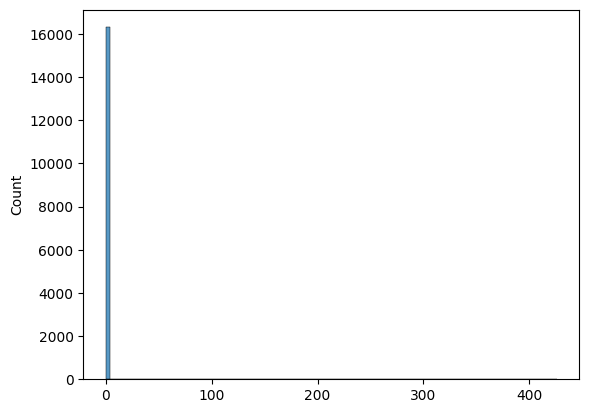

In [118]:
sns.histplot(heatmap_input.flatten(),bins=100)

/home/nikolas/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/nikolas/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


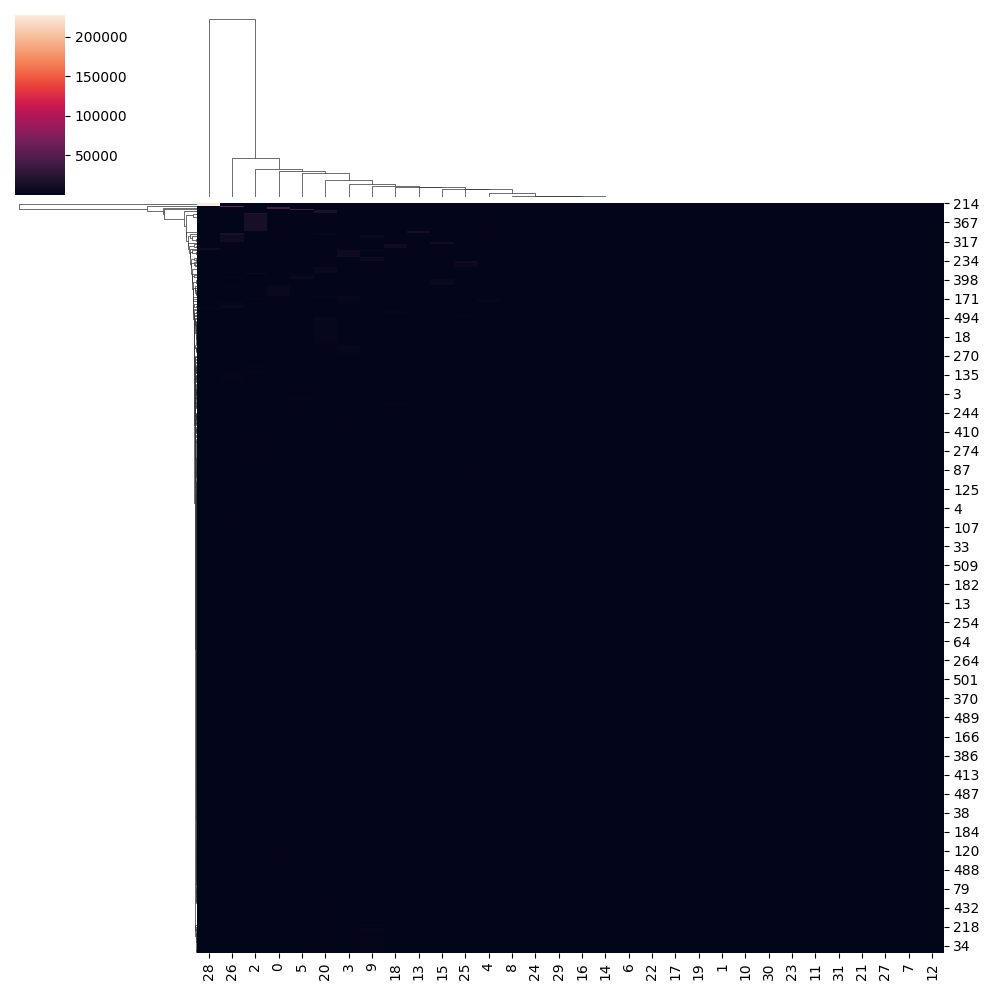

In [119]:
diff_2 = np.abs(normal_avg - linear_avg)
avg_2 = np.abs(normal_avg + linear_avg)/2
heatmap_input = diff_2/avg_2*100
sns.clustermap(heatmap_input)

<Axes: ylabel='Count'>

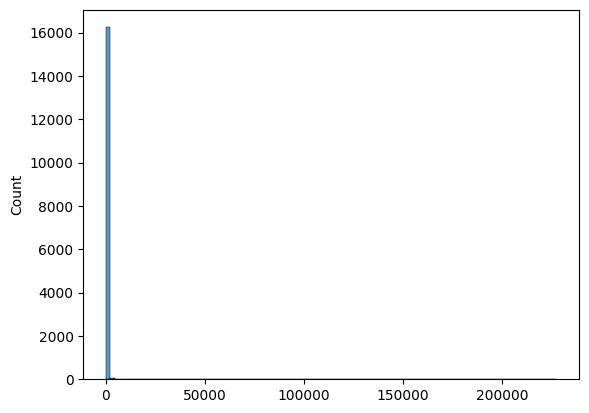

In [120]:
sns.histplot(heatmap_input.flatten(),bins=100)

In [121]:
import math
def generate_projection_matrix(m, d, device, orthogonal=True):
    """
    Generates a random projection matrix of shape (m, d).
    If orthogonal, returns an orthogonal matrix.
    """
    if orthogonal:
        mat = torch.randn(d, m, device=device)
        q, _ = torch.linalg.qr(mat)  # q: (d, m)
        return q.t()  # (m, d)
    else:
        return torch.randn(m, d, device=device)

def performer_feature_map(x, projection_matrix):
    """
    Cooler kernel trick:
      φ(x) = exp(-||x||^2/2) * [cos(xΩ^T), sin(xΩ^T)] / sqrt(m)
    x: (B, L, H, D), projection_matrix: (m, D)
    Returns: (B, L, H, 2*m)
    """
    B, L, H, D = x.shape
    m = projection_matrix.shape[0]
    # Flatten for matrix multiplication: (B*L*H, D)
    x_flat = x.reshape(-1, D)
    # Dot product: (B*L*H, m)
    proj = torch.matmul(x_flat, projection_matrix.t())
    # Norm factor: exp(-||x||^2/2)
    norm_factor = torch.exp(- (x_flat ** 2).sum(dim=1, keepdim=True) / 2)
    # Compute cosine and sine parts
    cos_part = torch.cos(proj)
    sin_part = torch.sin(proj)
    phi = torch.cat([cos_part, sin_part], dim=1)  # (B*L*H, 2*m)
    phi = norm_factor * phi / math.sqrt(m)
    return phi.reshape(B, L, H, -1)

def performer_attention(Q, K, V, projection_matrix, eps=1e-6):
    """
    Performer (FAVOR+) attention.
    Q, K, V: (B, L, H, D)
    projection_matrix: (m, D)
    Returns output: (B, L, H, D)
    """
    B, L, H, D = Q.shape
    # Compute feature maps
    phi_Q = performer_feature_map(Q, projection_matrix)  # (B, L, H, 2*m)
    phi_K = performer_feature_map(K, projection_matrix)  # (B, L, H, 2*m)
    # Rearrange to (B, H, L, 2*m)
    phi_Q = phi_Q.transpose(1,2)
    phi_K = phi_K.transpose(1,2)
    V = V.transpose(1,2)  # (B, H, L, D)
    
    # Compute numerator: (B, H, L, D) = phi_Q @ (phi_K^T V)
    KV = torch.matmul(phi_K.transpose(-2, -1), V)  # (B, H, 2*m, D)
    numerator = torch.matmul(phi_Q, KV)            # (B, H, L, D)
    
    # Compute denominator: (B, H, L, 1) = phi_Q @ (phi_K^T ones)
    ones = torch.ones((B, H, L, 1), device=Q.device)
    denominator = torch.matmul(phi_Q, torch.matmul(phi_K.transpose(-2, -1), ones))
    
    out = numerator / (denominator + eps)  # (B, H, L, D)
    return out.transpose(1,2)  # (B, L, H, D)

# Generate a projection matrix for Performer feature mapping
num_features = 32  # number of random features; adjust for accuracy vs speed trade-off
proj_matrix = generate_projection_matrix(num_features, head_dim, device, orthogonal=True)


In [122]:
# Warm-up iterations
for _ in range(5):
    _ = normal_attention(Q, K, V)
    _ = flash_attention(qkv)
    _ = performer_attention(Q, K, V, proj_matrix)

# Time Normal Attention
start = time.time()
normal_out = normal_attention(Q, K, V)
if device.type == 'cuda': torch.cuda.synchronize()
normal_time = time.time() - start

# Time Flash Attention
start = time.time()
flash_out = flash_attention(qkv)
if device.type == 'cuda': torch.cuda.synchronize()
flash_time = time.time() - start

# Time Performer Attention
start = time.time()
performer_out = performer_attention(Q, K, V, proj_matrix)
if device.type == 'cuda': torch.cuda.synchronize()
performer_time = time.time() - start

print(f"Normal attention time:    {normal_time*1000:.2f} ms")
print(f"Flash attention time:     {flash_time*1000:.2f} ms")
print(f"Performer attention time: {performer_time*1000:.2f} ms")

# Compare outputs: compute relative differences (using normal attention as reference)
diff_flash = torch.norm(normal_out - flash_out) / torch.norm(normal_out)
diff_performer = torch.norm(normal_out - performer_out) / torch.norm(normal_out)
print(f"Relative difference (Normal vs Flash):    {diff_flash.item():.4e}")
print(f"Relative difference (Normal vs Performer): {diff_performer.item():.4e}")

###############################################
# (Optional) Visualize a portion of the outputs
###############################################
# For example, average over heads and print first 5 token representations
normal_avg = normal_out.mean(dim=2).squeeze(0)      # (L, D)
flash_avg  = flash_out.mean(dim=2).squeeze(0)
performer_avg = performer_out.mean(dim=2).squeeze(0)

print("\nFirst 5 token representations (Normal attention):")
print(normal_avg[:5])
print("\nFirst 5 token representations (Flash attention):")
print(flash_avg[:5])
print("\nFirst 5 token representations (Performer attention):")
print(performer_avg[:5])


Normal attention time:    0.30 ms
Flash attention time:     0.37 ms
Performer attention time: 1.17 ms
Relative difference (Normal vs Flash):    3.1815e-04
Relative difference (Normal vs Performer): 1.0990e+00

First 5 token representations (Normal attention):
tensor([[-2.1756e-05,  3.2641e-02, -1.1363e-02,  6.2514e-04,  9.4590e-03,
          5.6709e-03,  3.5619e-02,  3.7037e-02, -3.2237e-02,  5.1495e-03,
          2.2321e-02,  3.8872e-02, -6.5262e-02,  1.4114e-02, -3.8732e-02,
          1.2479e-02,  1.0925e-02,  2.7176e-02, -3.5545e-03,  2.8619e-02,
          2.2766e-02,  4.3543e-02,  2.1709e-02, -2.8245e-02, -1.3215e-02,
          1.2096e-02,  1.1809e-02,  6.1791e-02,  1.6090e-02, -6.5931e-03,
          2.3705e-02, -3.2675e-02],
        [ 6.2338e-03,  2.4758e-02,  6.6691e-03, -8.4301e-03,  2.7448e-02,
         -8.4703e-03,  3.3059e-02,  4.3156e-02, -1.3518e-02,  1.0012e-02,
          1.6871e-02,  4.4614e-02, -5.1316e-02,  1.9046e-02, -3.1338e-02,
          4.8685e-03,  2.3625e-02,  1.

In [134]:
performer_avg = performer_out.mean(dim=2).squeeze(0).detach().cpu().numpy()  
normal_avg = normal_out.mean(dim=2).squeeze(0).detach().cpu().numpy()  
flash_avg = flash_out.mean(dim=2).squeeze(0).detach().cpu().numpy()  

/home/nikolas/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/nikolas/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


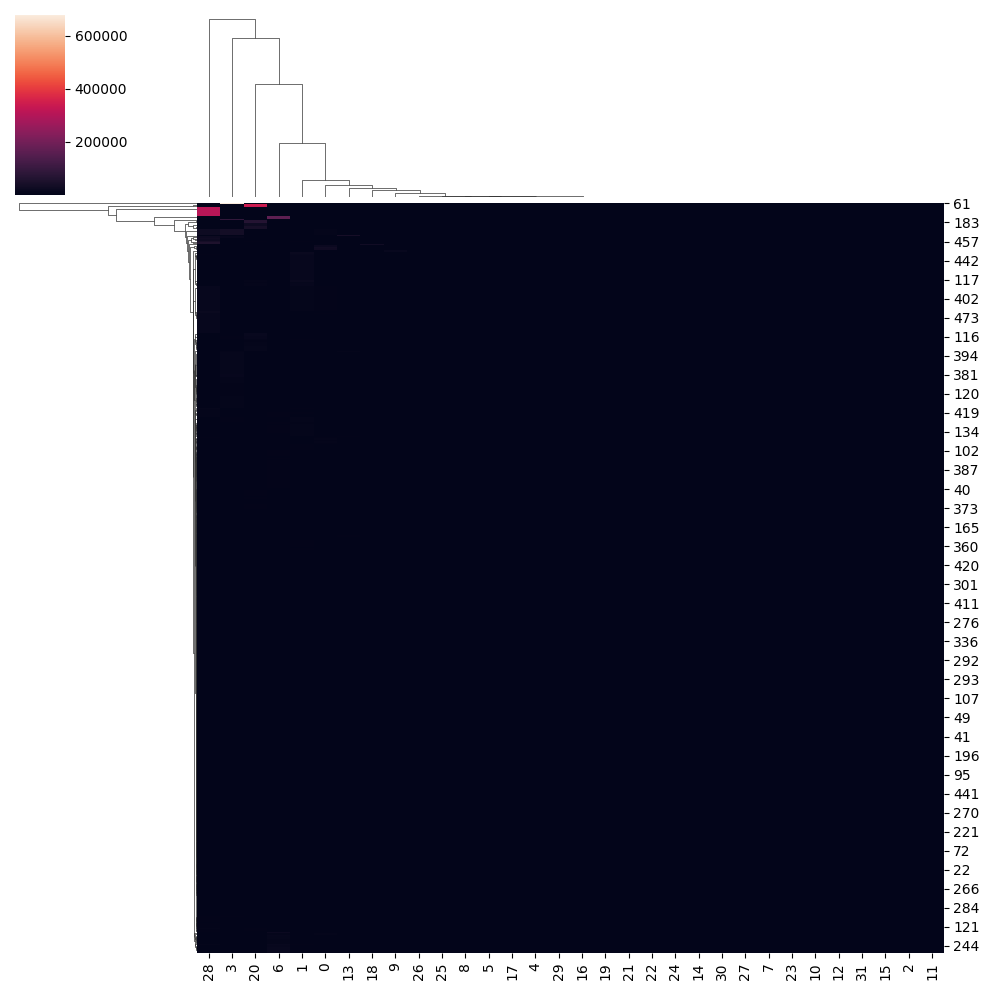

In [126]:
diff_2 = np.abs(normal_avg - performer_avg)
avg_2 = np.abs(normal_avg + performer_avg)/2
heatmap_input = diff_2/avg_2*100
sns.clustermap(heatmap_input)

<Axes: ylabel='Count'>

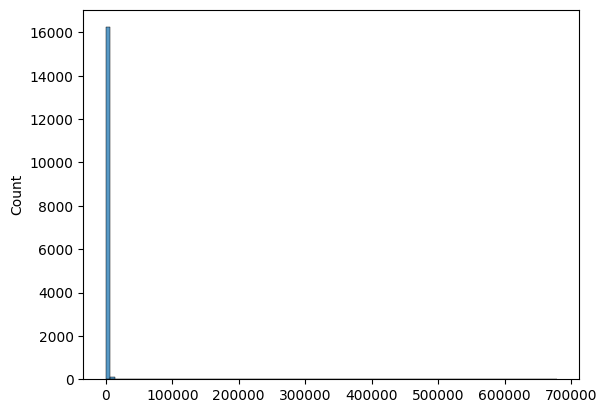

In [127]:
sns.histplot(heatmap_input.flatten(),bins=100)

In [135]:
np.sum(heatmap_input.flatten() < 100) / heatmap_input.flatten().shape

array([0.53900146])

/home/nikolas/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/nikolas/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


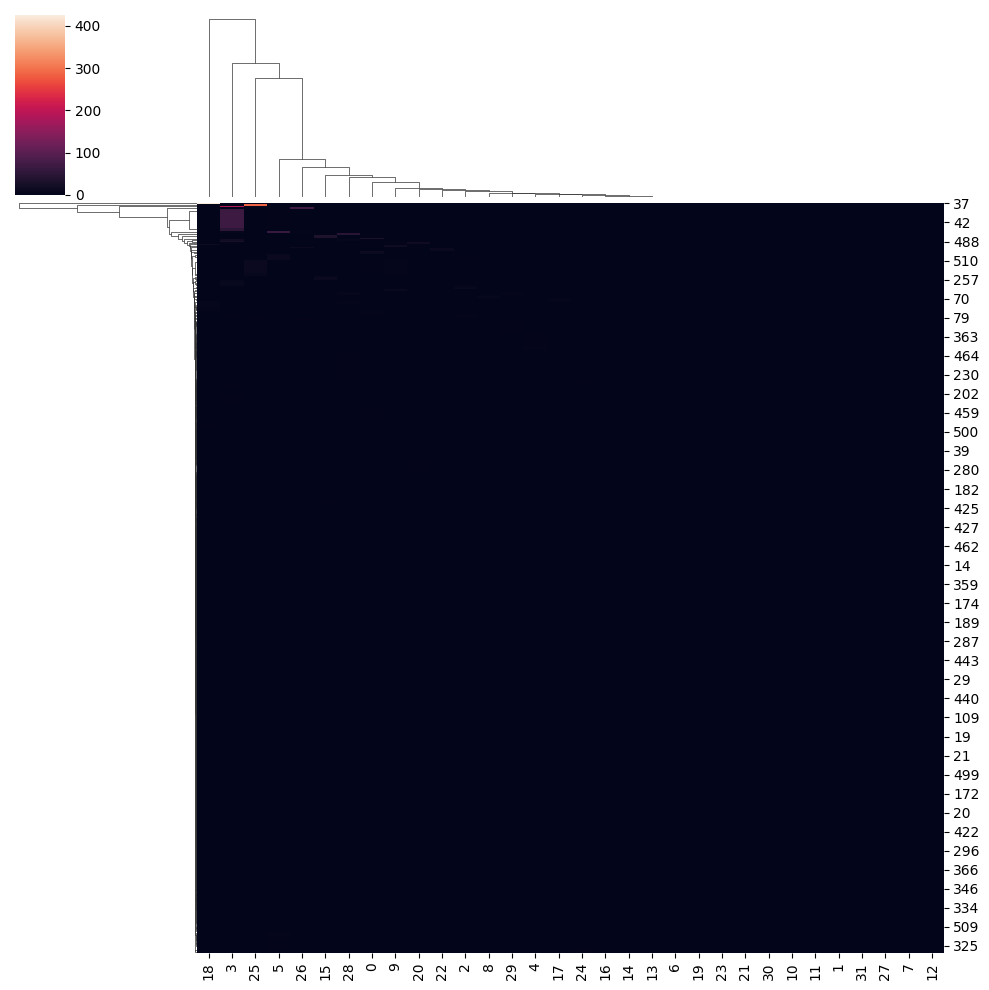

In [136]:
diff_2 = np.abs(normal_avg - flash_avg)
avg_2 = np.abs(normal_avg + flash_avg)/2
heatmap_input = diff_2/avg_2*100
sns.clustermap(heatmap_input)

<Axes: ylabel='Count'>

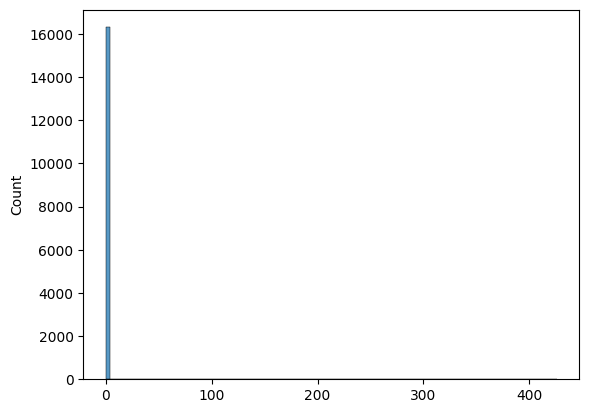

In [137]:
sns.histplot(heatmap_input.flatten(),bins=100)

In [140]:
np.sum(heatmap_input.flatten() < 5) / heatmap_input.flatten().shape

array([0.99560547])